In [21]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import watershed
from skimage.io import imread
from skimage.color import rgb2gray, label2rgb
import scipy.ndimage as nd
from skimage.filters import sobel, threshold_yen
import cv2
import torch
import torch.optim as optim
from torch.autograd import Variable
import cv2
import sys
import os
import numpy as np
from skimage import segmentation
import torch.nn.init
sys.path.append(os.path.abspath('/home/gabricp/tfg'))
from models.segmodel import SegModel

## Region Based Segmentation

In [12]:
IMAGE_NAME = 6
DATA_PATH = '/home/gabricp/tfg/data/raw/'
DEST_PATH = '/home/gabricp/tfg/data/segmentation_region/'

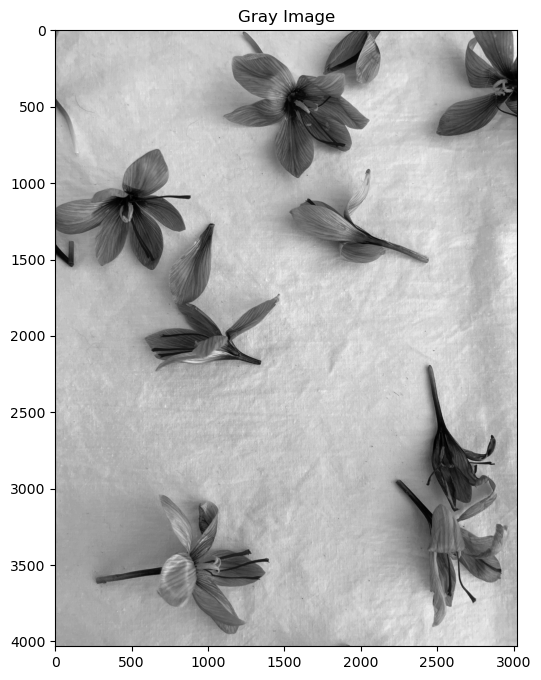

In [13]:
image = imread(f'{DATA_PATH}{IMAGE_NAME}.jpeg')
image_gray = rgb2gray(image)
plt.imshow(image_gray, cmap='gray')
plt.title('Gray Image')
plt.show()

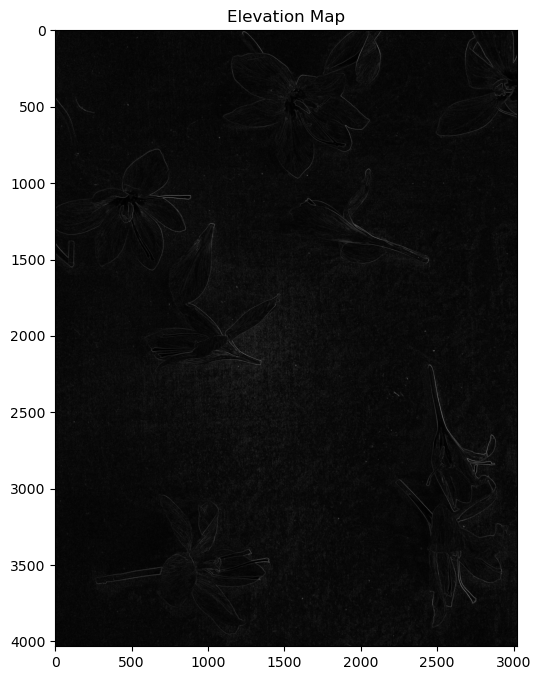

In [14]:
plt.rcParams["figure.figsize"] = (12,8)
elevation_map = sobel(image_gray)
plt.imshow(elevation_map, cmap='gray')
plt.title('Elevation Map')
plt.show()

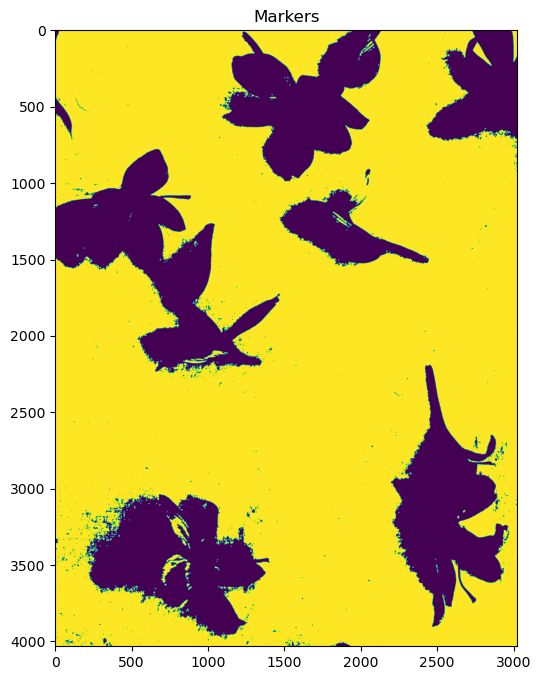

In [16]:
thresh = threshold_yen(image_gray)
markers = np.zeros_like(image_gray)
markers[image_gray < thresh] = 1
markers[image_gray >= thresh] = 2 
#Supresion del ruido
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
markers = cv2.morphologyEx(markers.astype(np.uint8), 
                           cv2.MORPH_OPEN,
                           kernel,
                           iterations=2)
plt.imshow(markers)
plt.title('Markers')
plt.show()

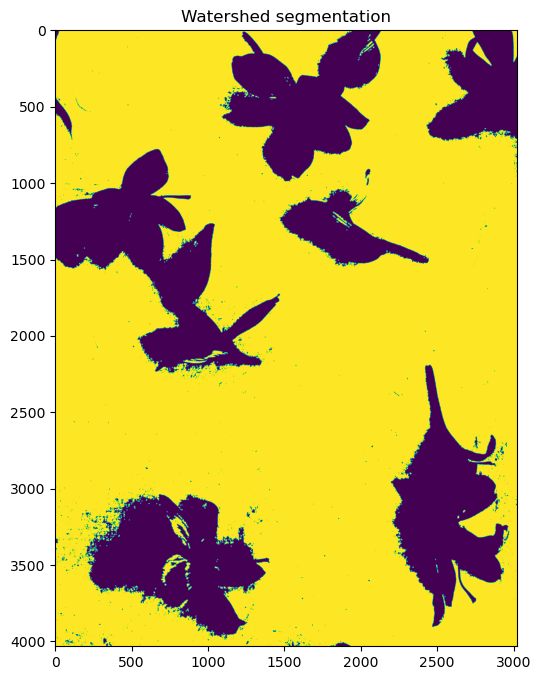

In [17]:
segmentation = watershed(elevation_map, markers=markers)

plt.imshow(segmentation)
plt.title('Watershed segmentation')
plt.show()

## Convolutional Segmentation

In [36]:
use_cuda = torch.cuda.is_available()
DATA_PATH = '/home/gabricp/tfg/data/raw/'
DATA_DEST = '/home/gabricp/tfg/data/segmentation/'
MAX_ITER = 300
MIN_LABELS = 2
NCHANNEL = 100
LR = 0.1
NCONV = 2
NUM_SUPERPIXELS = 10000
COMPACTNESS = 100
VISUALIZE = True

In [26]:
raw_images = os.listdir(DATA_PATH)
segmented_images = os.listdir(DATA_DEST)
images_to_segment = [image for image in raw_images if image not in segmented_images]
random_image = np.random.choice(raw_images)

In [ ]:

im = cv2.imread(DATA_PATH + random_image)
im = cv2.resize(im, (1440, 1080))
data = torch.from_numpy( np.array([im.transpose((2, 0, 1)).astype('float32')/255.]) )
if use_cuda:
    data = data.cuda()
data = Variable(data)

# slic
labels = segmentation.slic(im, compactness=COMPACTNESS, n_segments=NUM_SUPERPIXELS)
labels = labels.reshape(im.shape[0]*im.shape[1])
u_labels = np.unique(labels)
l_inds = []
for i in range(len(u_labels)):
    l_inds.append( np.where( labels == u_labels[ i ] )[ 0 ] )

# train
model = SegModel( data.size(1), NCHANNEL, NCONV)
if use_cuda:
    model.cuda()
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9)
label_colours = np.random.randint(255,size=(100,3))
for batch_idx in range(MAX_ITER):
    # forwarding
    optimizer.zero_grad()
    output = model( data )[ 0 ]
    output = output.permute( 1, 2, 0 ).contiguous().view( -1, NCHANNEL )
    ignore, target = torch.max( output, 1 )
    im_target = target.data.cpu().numpy()
    nLabels = len(np.unique(im_target))
    if VISUALIZE:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        plt.imshow( im_target_rgb )
        plt.show()

    
    for i in range(len(l_inds)):
        labels_per_sp = im_target[ l_inds[ i ] ]
        u_labels_per_sp = np.unique( labels_per_sp )
        hist = np.zeros( len(u_labels_per_sp) )
        for j in range(len(hist)):
            hist[ j ] = len( np.where( labels_per_sp == u_labels_per_sp[ j ] )[ 0 ] )
        im_target[ l_inds[ i ] ] = u_labels_per_sp[ np.argmax( hist ) ]
    target = torch.from_numpy( im_target )
    if use_cuda:
        target = target.cuda()
    target = Variable( target )
    loss = loss_fn(output, target)
    loss.backward()
    optimizer.step()

    print (batch_idx, '/', MAX_ITER, ':', nLabels, loss.item())

    if nLabels <= MIN_LABELS:
        print ("nLabels", nLabels, "reached minLabels", MIN_LABELS, ".")
        break

    if not VISUALIZE:
        output = model( data )[ 0 ]
        output = output.permute( 1, 2, 0 ).contiguous().view( -1, NCHANNEL )
        ignore, target = torch.max( output, 1 )
        im_target = target.data.cpu().numpy()
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
    if VISUALIZE and batch_idx in [1,MAX_ITER % 2,MAX_ITER]:
        im_target_rgb = np.array([label_colours[ c % 100 ] for c in im_target])
        im_target_rgb = im_target_rgb.reshape( im.shape ).astype( np.uint8 )
        plt.imshow( im_target_rgb )
        plt.show() 


error: OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
